**Title**: "Your Personalized Movie Picks: A Guide to Building a Movie Recommendation System"



# 1- Introduction:

Have you ever spent hours scrolling through an endless list of movies, unsure of what to watch next? Or perhaps you've wished for a more personalized movie-watching experience that caters to your unique tastes and preferences. If you're nodding your head, then you're in the right place!

In this notebook, we embark on a journey to demystify the world of movie recommendation systems. We won't bore you with complicated technical jargon or labyrinthine corporate buzzwords; instead, we'll focus on creating a simple and effective movie recommendation system that anyone can understand and implement.

Imagine having a movie buddy who knows your cinematic preferences inside out. This notebook will help you build just that! Whether you're a movie enthusiast, a casual viewer, or someone who simply wants to make movie nights more enjoyable, we've got you covered.

Together, we'll explore the fundamentals of recommendation systems, delve into the nuts and bolts of data, and ultimately craft a system that provides tailored movie recommendations based on your personal tastes. No prior expertise is required – just your curiosity and a desire to enhance your movie-watching experience.

So, grab your popcorn, fire up your favorite streaming platform, and let's embark on this exciting journey to create your very own personalized movie recommendation system!

Certainly, let's simplify the explanations of these three types of recommender systems:

1. **Demographic Filtering**:
   - This type of recommender system gives general recommendations to all users based on factors like movie popularity and genre.
   - It assumes that movies that are popular and well-reviewed are likely to be enjoyed by most people.
   - It doesn't consider individual differences and can be seen as too simplistic.

2. **Content-Based Filtering**:
   - Content-based systems suggest similar items based on the characteristics of a specific item.
   - They use information like genre, director, actors, and descriptions to make recommendations.
   - The idea is that if you liked one item, you'll probably like items that are similar in these aspects.

3. **Collaborative Filtering**:
   - This system connects users with similar tastes and offers recommendations based on this connection.
   - It doesn't rely on item details like content-based systems.
   - Instead, it looks at what other users with similar preferences have liked and suggests those items.

These systems help people discover new movies, music, or other items they might enjoy based on their past preferences or general trends.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path


In [10]:
#load the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
#data for part 3, 4, and 5
dcr=pd.read_csv(r'/content/drive/MyDrive/tmdb_5000_credits.csv')
dmo=pd.read_csv(r'/content/drive/MyDrive/tmdb_5000_movies.csv')



In [3]:
# data for collaborative filtering
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

978202/978202 [==============================] - 1s 1us/step
Extracting all the files now...
Done!


In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [7]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


# 2- Collaborative Filtering


We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).

In [9]:
C= df['rating'].mean()
C

3.5015569

In [16]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [17]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [18]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 17s 11ms/step - loss: 0.6363 - val_loss: 0.6203
Epoch 2/5
1418/1418 [==============================] - 15s 11ms/step - loss: 0.6130 - val_loss: 0.6175
Epoch 3/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.6086 - val_loss: 0.6126
Epoch 4/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.6070 - val_loss: 0.6132
Epoch 5/5
1418/1418 [==============================] - 23s 16ms/step - loss: 0.6073 - val_loss: 0.6130


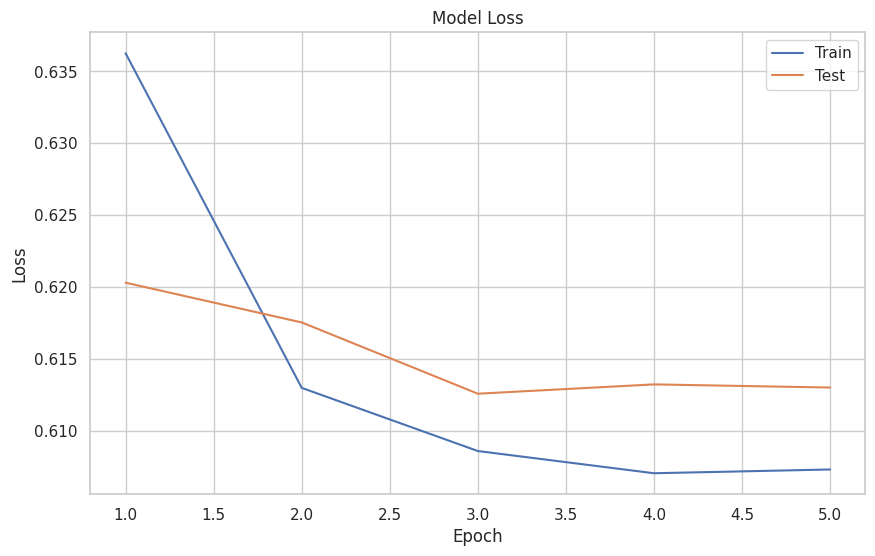

In [19]:
sns.set(style="whitegrid")  # Set the style of the plot

# Plot the training and validation loss using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["loss"], label="Train")
sns.lineplot(x=range(1, len(history.history["val_loss"]) + 1), y=history.history["val_loss"], label="Test")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

Batch Size: 32, Epochs: 3, Learning Rate: 0.001
Train Loss: 0.605819582939148, Validation Loss: 0.6102744340896606

Batch Size: 32, Epochs: 3, Learning Rate: 0.01
Train Loss: 7.787621974945068, Validation Loss: 6.108014106750488

Batch Size: 32, Epochs: 3, Learning Rate: 0.1
Train Loss: 806.3770141601562, Validation Loss: 733.5621948242188

Batch Size: 32, Epochs: 5, Learning Rate: 0.001
Train Loss: 0.6028521060943604, Validation Loss: 0.6093178391456604

Batch Size: 32, Epochs: 5, Learning Rate: 0.01
Train Loss: 9.628257751464844, Validation Loss: 8.020634651184082

Batch Size: 32, Epochs: 5, Learning Rate: 0.1
Train Loss: 1054.5360107421875, Validation Loss: 899.7455444335938

Batch Size: 32, Epochs: 7, Learning Rate: 0.001
Train Loss: 0.6013841032981873, Validation Loss: 0.609169602394104

Batch Size: 32, Epochs: 7, Learning Rate: 0.01
Train Loss: 10.660242080688477, Validation Loss: 9.126448631286621

Batch Size: 32, Epochs: 7, Learning Rate: 0.1
Train Loss: 1233.3211669921875, Val

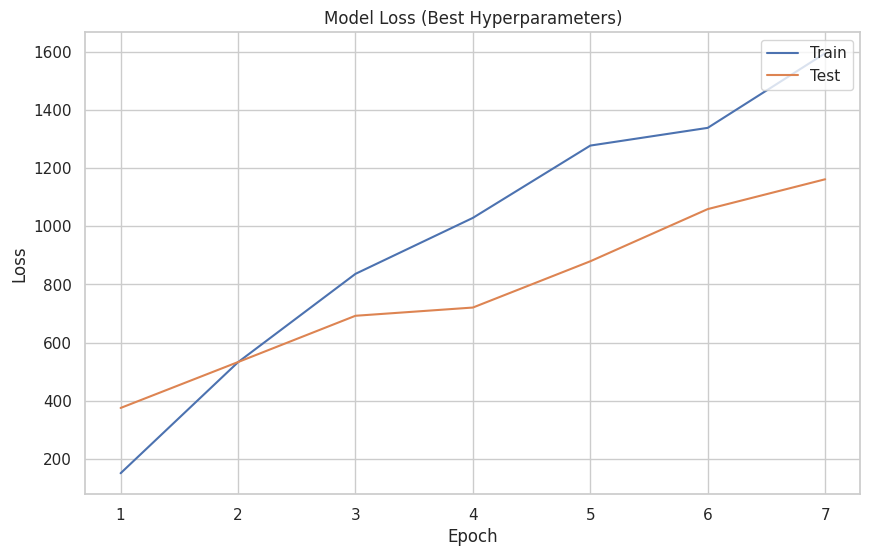

In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Define your data and model here

# Define hyperparameter values to try
batch_sizes = [32, 64, 128]
num_epochs = [3, 5, 7]
learning_rates = [0.001, 0.01, 0.1]

# Initialize lists to store results
train_losses = []
val_losses = []

for batch_size in batch_sizes:
    for epochs in num_epochs:
        for lr in learning_rates:
            # Create and compile the model
            model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
            model.compile(
                loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=keras.optimizers.Adam(learning_rate=lr),
            )

            # Train the model
            history = model.fit(
                x=x_train,
                y=y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=0,  # Set to 1 for training details
                validation_data=(x_val, y_val),
            )

            # Store the results
            train_loss = history.history["loss"][-1]
            val_loss = history.history["val_loss"][-1]

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {lr}")
            print(f"Train Loss: {train_loss}, Validation Loss: {val_loss}\n")

# Find the best hyperparameters
best_index = np.argmin(val_losses)
best_batch_size = batch_sizes[best_index // (len(num_epochs) * len(learning_rates))]
best_epochs = num_epochs[(best_index % (len(num_epochs) * len(learning_rates))) // len(learning_rates)]
best_lr = learning_rates[best_index % len(learning_rates)]
best_val_loss = val_losses[best_index]

print(f"Best Hyperparameters:")
print(f"Batch Size: {best_batch_size}, Epochs: {best_epochs}, Learning Rate: {best_lr}")
print(f"Best Validation Loss: {best_val_loss}")

# Plot the training and validation loss using Seaborn for the best hyperparameters
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["loss"], label="Train")
sns.lineplot(x=range(1, len(history.history["val_loss"]) + 1), y=history.history["val_loss"], label="Test")
plt.title("Model Loss (Best Hyperparameters)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()


based on out put result we understand:

1.   Batch size of 32
2.   Epochs of 7
3.   Learning rate of 0.001



In [33]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/10
2836/2836 [==============================] - 25s 9ms/step - loss: 0.5938 - val_loss: 0.6046
Epoch 2/10
2836/2836 [==============================] - 26s 9ms/step - loss: 0.5928 - val_loss: 0.6041
Epoch 3/10
2836/2836 [==============================] - 28s 10ms/step - loss: 0.5924 - val_loss: 0.6038
Epoch 4/10
2836/2836 [==============================] - 24s 9ms/step - loss: 0.5919 - val_loss: 0.6039
Epoch 5/10
2836/2836 [==============================] - 30s 10ms/step - loss: 0.5916 - val_loss: 0.6039
Epoch 6/10
2836/2836 [==============================] - 27s 10ms/step - loss: 0.5911 - val_loss: 0.6036
Epoch 7/10
2836/2836 [==============================] - 23s 8ms/step - loss: 0.5905 - val_loss: 0.6038
Epoch 8/10
2836/2836 [==============================] - 23s 8ms/step - loss: 0.5904 - val_loss: 0.6033
Epoch 9/10
2836/2836 [==============================] - 24s 8ms/step - loss: 0.5900 - val_loss: 0.6036
Epoch 10/10
2836/2836 [==============================] - 22s 8ms/step 

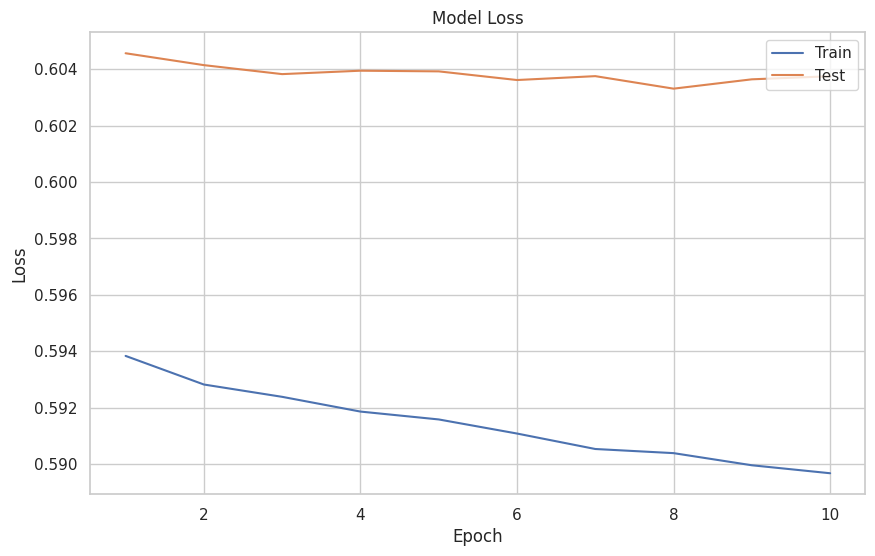

In [34]:
sns.set(style="whitegrid")  # Set the style of the plot

# Plot the training and validation loss using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["loss"], label="Train")
sns.lineplot(x=range(1, len(history.history["val_loss"]) + 1), y=history.history["val_loss"], label="Test")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

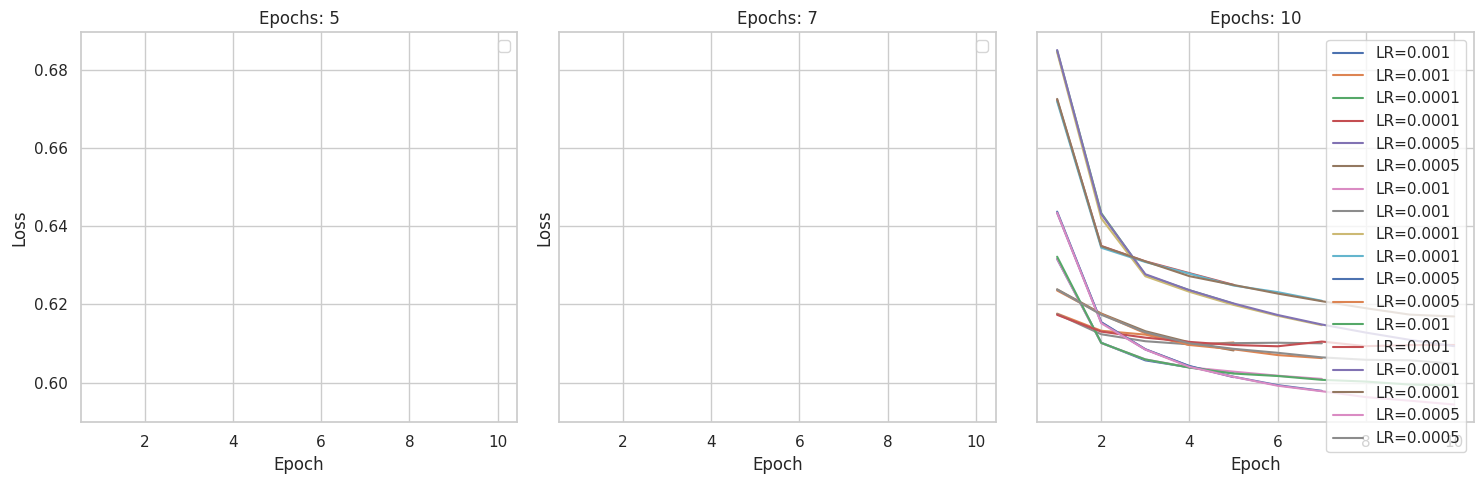

In [32]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Define your data and model here

# Define hyperparameter values to try
batch_size = 32
num_epochs = [5, 7, 10]
learning_rates = [0.001, 0.0001, 0.0005]

# Create a grid of subplots for hyperparameter tuning visualization
fig, axes = plt.subplots(1, len(num_epochs), figsize=(15, 5), sharex=True, sharey=True)

for j, epochs in enumerate(num_epochs):
    for k, lr in enumerate(learning_rates):
        # Create and compile the model
        model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=keras.optimizers.Adam(learning_rate=lr),
        )

        # Train the model
        history = model.fit(
            x=x_train,
            y=y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,  # Set to 1 for training details
            validation_data=(x_val, y_val),
        )

        # Plot the training and validation loss using Seaborn in the corresponding subplot
        ax = axes[j]
        sns.lineplot(x=range(1, epochs + 1), y=history.history["loss"], label=f"LR={lr}")
        sns.lineplot(x=range(1, epochs + 1), y=history.history["val_loss"], label=f"LR={lr}")
        ax.set_title(f"Epochs: {epochs}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(loc="upper right")

# Adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()


In [24]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

298/298 [==============================] - 1s 1ms/step
Showing recommendations for user: 41
Movies with high ratings from user
--------------------------------
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Clockwork Orange, A (1971) : Crime|Drama|Sci-Fi|Thriller
Zoolander (2001) : Comedy
Along Came Polly (2004) : Comedy|Romance
Kill Bill: Vol. 2 (2004) : Action|Drama|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Toy Story (1995) : Adventure|Animation|Children|Comedy|Fantasy
Wedding Planner, The (2001) : Comedy|Romance
Joe Dirt (2001) : Adventure|Comedy|Mystery|Romance
Josie and the Pussycats (2001) : Comedy
Whatever Works (2009) : Comedy|Romance
Ghosts of Girlfriends Past (2009) : Comedy|Fantasy|Romance
Brüno (Bruno) (2009) : Comedy
Pixels (2015) : Action|Comedy|Sci-Fi
Fantastic Beasts and Where to Find Them (2016) : Fantasy
Fracchia contro Dracula (1985) : Comedy|Horror


# 3- Data preprocessing  


In [12]:
dmo

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

In [13]:
dcr

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [14]:
dcr.columns = ['id','tittle','cast','crew']
dmo= dmo.merge(dcr,on='id')

In [15]:
dmo

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]",...,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],...,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,Newlyweds,"[{""c

In [35]:
m= dmo['vote_count'].quantile(0.9)
m


1838.4000000000015

In [36]:
C= dmo['vote_average'].mean()
C

6.092171559442016

In [37]:
dmo.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
tittle                     0
cast                       0
crew                       0
dtype: int64

In [38]:
q_movies = dmo.copy().loc[dmo['vote_count'] >= m]
q_movies.shape

(481, 23)

In [45]:
dmo['release_date'] = pd.to_datetime(dmo['release_date'])
dmo.rename(columns={'title_y':'title'}, inplace=True) #rename col
del dmo['tittle'], dmo['id'] #No need for the id of the movies once the tables are joined
del dmo["tagline"]  #it doesn't really hold any information


In [46]:

dmo = dmo[dmo['status'] == 'Released'] #keep only released movies

del dmo['status'], dmo['original_title'] #no need for these columns anymore

In [47]:
dmo.loc[dmo["budget"] == 0.0,  "budget"] = dmo["budget"].mean() #mean for null values
dmo.loc[dmo["runtime"] == 0.0, "runtime"] = dmo["runtime"].mean() #mean for null values

In [48]:
dmo["year"] = dmo["release_date"].dt.year #get year
dmo["month"] = dmo["release_date"].dt.month #get month
dmo["day"] = dmo["release_date"].dt.day #get day
dmo["dow"] = dmo["release_date"].dt.dayofweek #get dow for visualization
dmo["profit"] = dmo["revenue"] - dmo["budget"] #calculate profit

<ipython-input-48-9c8c2999406d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dmo["year"] = dmo["release_date"].dt.year #get year
<ipython-input-48-9c8c2999406d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dmo["month"] = dmo["release_date"].dt.month #get month
<ipython-input-48-9c8c2999406d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [50]:
from math import floor
def extract_decade(x):
    return str(floor(x/10)*10)+"s" #Change the last digit with 0 and add "s" => 2015 => "2010s"

final_movies_df= dmo.fillna(0)
final_movies_df["decade"] = final_movies_df["year"].apply(extract_decade)
final_movies_df = final_movies_df[(final_movies_df['decade'] != '1910s') & (final_movies_df['decade'] != '0s')] #outliers
final_movies_df = final_movies_df.sort_values(by=['decade'], ascending=True)

In [52]:
final_movies_df.isna().sum()

budget                  0
genres                  0
homepage                0
keywords                0
original_language       0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
tagline                 0
title                   0
vote_average            0
vote_count              0
cast                    0
crew                    0
year                    0
month                   0
day                     0
dow                     0
profit                  0
decade                  0
dtype: int64

In [51]:
print('The run time statistics are as follows')
print(final_movies_df["runtime"].describe()[['mean','std','25%','50%','75%','max']])
max_runtime_id = final_movies_df["runtime"].idxmax()
print(final_movies_df.loc[max_runtime_id][['title','runtime','year']])

The run time statistics are as follows
mean    107.610098
std      20.758394
25%      94.000000
50%     104.000000
75%     118.000000
max     338.000000
Name: runtime, dtype: float64
title      Carlos
runtime     338.0
year       2010.0
Name: 2384, dtype: object


In [53]:
max_runtime_id = final_movies_df["runtime"].idxmax() #locate the movie with the max runtime
print(final_movies_df.loc[max_runtime_id][['title','runtime','year']])

title      Carlos
runtime     338.0
year       2010.0
Name: 2384, dtype: object


In [54]:
pop = final_movies_df["popularity"].idxmax()
print(final_movies_df.loc[pop][['title','profit','year','vote_average']])

title                Minions
profit          1082730962.0
year                  2015.0
vote_average             6.4
Name: 546, dtype: object


In [55]:
top = final_movies_df.nlargest(10,'vote_average')
print('Most voted')
top[['title','year','vote_average']]

Most voted


,title,year,vote_average
3519,Stiff Upper Lips,1998.0,10.0
4045,"Dancer, Texas Pop. 81",1998.0,10.0
4247,Me You and Five Bucks,2015.0,10.0
3992,Sardaarji,2015.0,9.5
2386,One Man's Hero,1999.0,9.3
1881,The Shawshank Redemption,1994.0,8.5
2970,There Goes My Baby,1994.0,8.5
2796,The Prisoner of Zenda,1937.0,8.4
3337,The Godfather,1972.0,8.4
2731,The Godfather: Part II,1974.0,8.3


In [56]:
final_movies_df.head()

,budget,genres,homepage,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,...,vote_average,vote_count,cast,crew,year,month,day,dow,profit,decade
4594,3.790000e+05,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10402, ""n...",0,"[{""id"": 4344, ""name"": ""musical""}, {""id"": 10229...",en,"Harriet and Queenie Mahoney, a vaudeville act,...",0.968865,"[{""name"": ""Metro-Goldwyn-Mayer (MGM)"", ""id"": 8...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1929-02-08 00:00:00,...,5.0,19,"[{""cast_id"": 8, ""character"": ""Eddie Kearns"", ""...","[{""credit_id"": ""5647d9b9c3a368260100563e"", ""de...",1929.0,2.0,8.0,4.0,3.979000e+06,1920s
4457,2.909267e+07,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 53, ""name...",0,"[{""id"": 212, ""name"": ""london england""}, {""id"":...",de,The rise and inevitable fall of an amoral but ...,1.824184,"[{""name"": ""Nero Films"", ""id"": 4903}]","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}]",1929-01-30 00:00:00,...,7.6,45,"[{""cast_id"": 7, ""character"": ""Lulu"", ""credit_i...","[{""credit_id"": ""52fe428ac3a36847f8026e81"", ""de...",1929.0,1.0,30.0,2.0,-2.909267e+07,1920s
4661,2.450000e+05,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",0,"[{""id"": 2504, ""name"": ""world war i""}, {""id"": 1...",en,The story of an idle rich boy who joins the US...,0.785744,"[{""name"": ""Metro-Goldwyn-Mayer (MGM)"", ""id"": 8...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1925-11-05 00:00:00,...,7.0,21,"[{""cast_id"": 23, ""character"": ""James Apperson""...","[{""credit_id"": ""52fe4381c3a36847f805922b"", ""de...",1925.0,11.0,5.0,3.0,2.175500e+07,1920s
2638,9.262000e+07,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 878, ""nam...",0,"[{""id"": 312, ""name"": ""man vs machine""}, {""id"":...",de,In a futuristic city sharply divided between t...,32.351527,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}]",1927-01-10 00:00:00,...,8.0,657,"[{""cast_id"": 10, ""character"": ""Maria"", ""credit...","[{""credit_id"": ""52fe420fc3a36847f8000c55"", ""de...",1927.0,1.0,10.0,0.0,-9.196958e+07,1920s
4200,1.644736e+06,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",0,"[{""id"": 2693, ""name"": ""monopoly""}, {""id"": 5728...",en,"Alice, the only relatively normal member of th...",3.426314,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1938-08-23 00:00:00,...,7.2,79,"[{""cast_id"": 2, ""character"": ""Alice Sycamore"",...","[{""credit_id"": ""52fe45539251416c9102e8cd"", ""de...",1938.0,8.0,23.0,1.0,5.788365e+06,1930s


In [57]:
most_profits = final_movies_df.nlargest(10,'profit')
most_profits[['title','profit','year','vote_average']]

,title,profit,year,vote_average
0,Avatar,2.550965e+09,2009.0,7.2
25,Titanic,1.645034e+09,1997.0,7.5
28,Jurassic World,1.363529e+09,2015.0,6.5
44,Furious 7,1.316249e+09,2015.0,7.3
16,The Avengers,1.299558e+09,2012.0,7.4
7,Avengers: Age of Ultron,1.125404e+09,2015.0,7.3
124,Frozen,1.124219e+09,2013.0,7.3
546,Minions,1.082731e+09,2015.0,6.4
329,The Lord of the Rings: The Return of the King,1.024889e+09,2003.0,8.1
31,Iron Man 3,1.015440e+09,2013.0,6.8


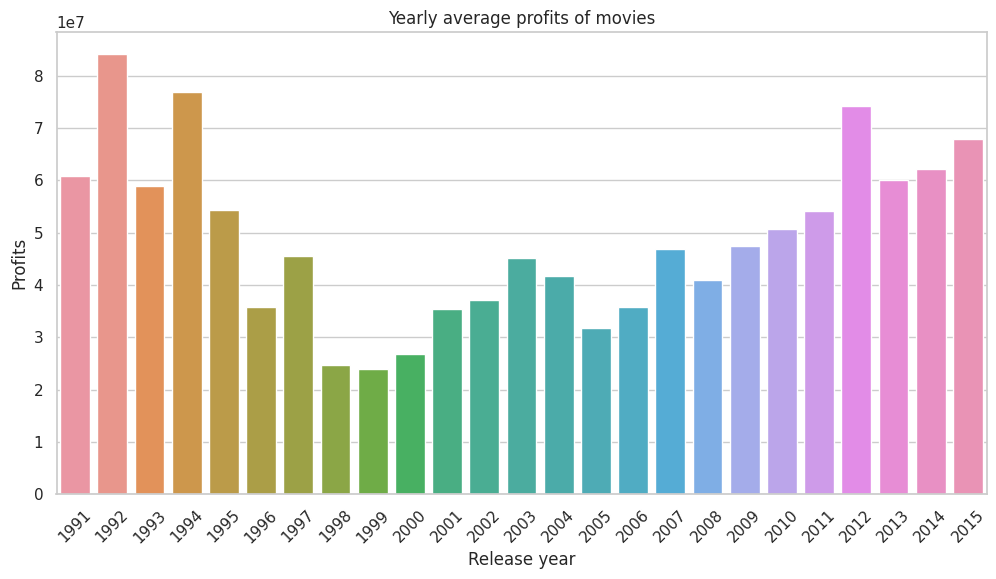

In [71]:
profits_per_year = final_movies_df[(final_movies_df["year"] > 1990) & (final_movies_df["year"] < 2016)].groupby("year").agg({"profit": "mean"})
profits_per_year.index = profits_per_year.index.astype(int)

sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(12, 6))  # Set the figure size

ax = sns.barplot(x=profits_per_year.index, y='profit', data=profits_per_year)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees

plt.xlabel('Release year')
plt.ylabel('Profits')
plt.title('Yearly average profits of movies')
plt.show()


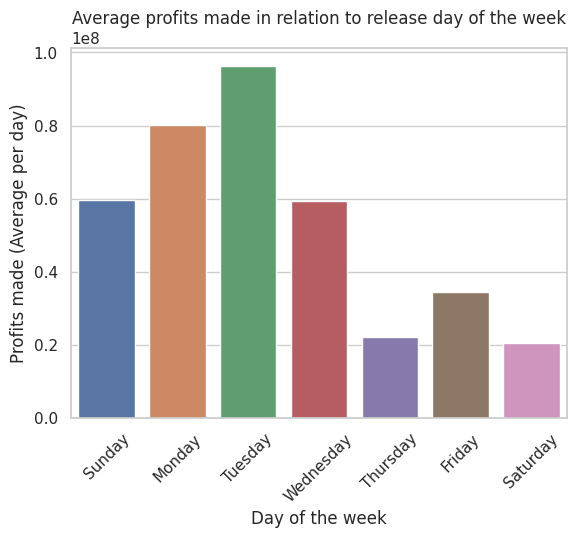

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

profit_by_dow = final_movies_df[final_movies_df["year"] > 1990].groupby(["dow"]).profit.mean().reset_index()
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.set(style="whitegrid")  # Set the style of the plot

# Create the barplot with rotated x-axis labels
ax = sns.barplot(x=days, y='profit', data=profit_by_dow)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees

plt.xlabel('Day of the week')
plt.ylabel('Profits made (Average per day)')
plt.title('Average profits made in relation to release day of the week')
plt.show()


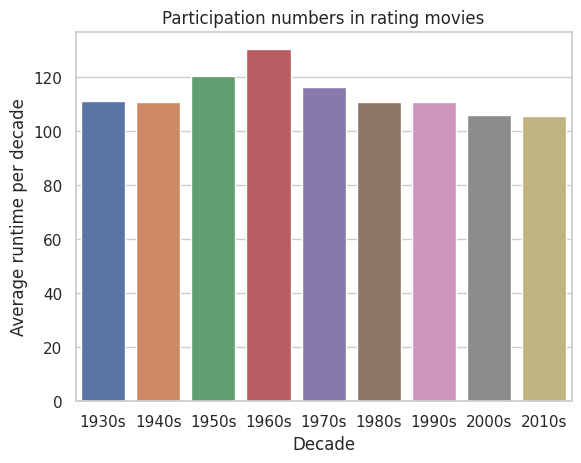

In [72]:
 #temp manipulation
df_by_vote = final_movies_df.groupby(['decade']).runtime.mean().reset_index()[1:] #remove 0s decade
sns.barplot(x='decade',y='runtime',data=df_by_vote)
plt.xlabel('Decade')
plt.ylabel('Average runtime per decade')
plt.title('Participation numbers in rating movies')
plt.show()

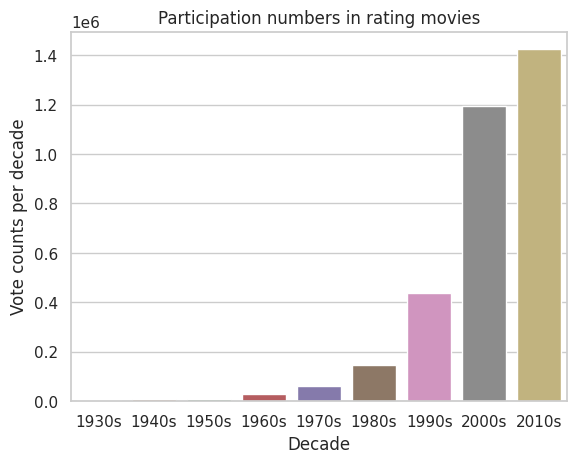

In [73]:
df_by_vote = final_movies_df.groupby(['decade']).vote_count.sum().reset_index()[1:] #remove 0s decade
sns.barplot(x='decade',y='vote_count',data=df_by_vote)
plt.xlabel('Decade')
plt.ylabel('Vote counts per decade')
plt.title('Participation numbers in rating movies')
plt.show()

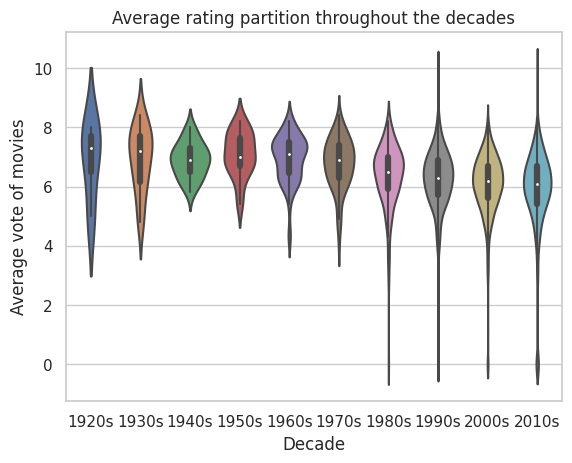

In [74]:
sns.violinplot(x='decade',y='vote_average',data=final_movies_df)
plt.title('Average rating partition throughout the decades')
plt.xlabel('Decade')
plt.ylabel('Average vote of movies')
plt.show()

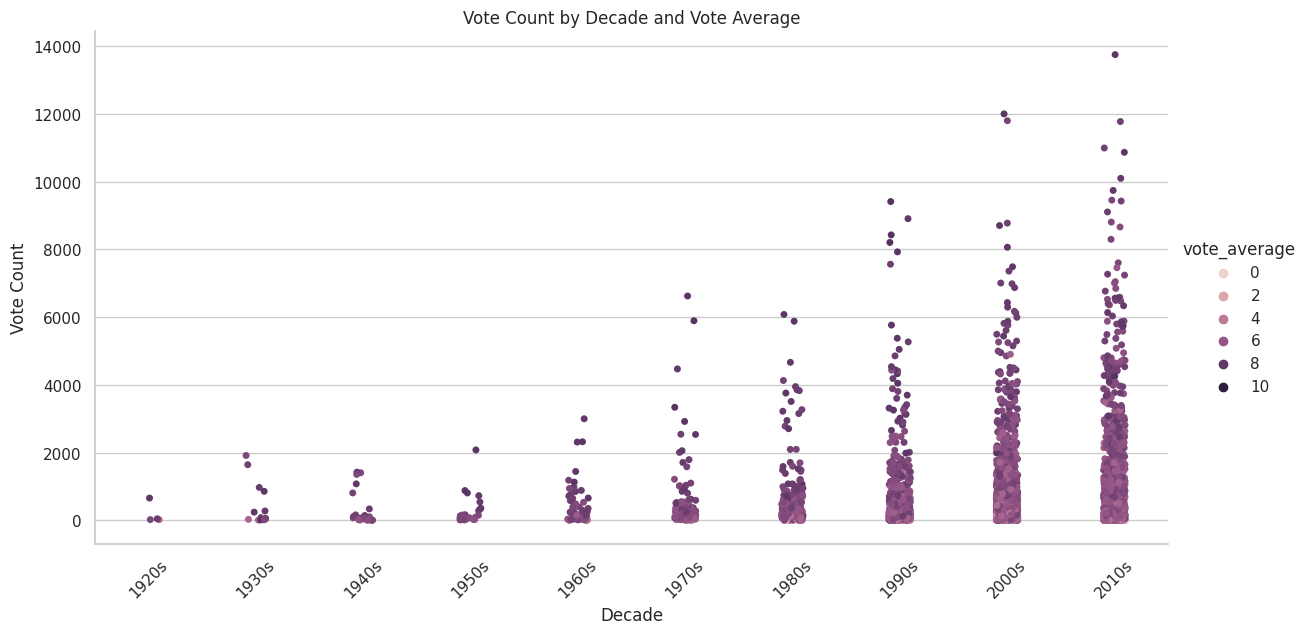

In [79]:


sns.set(style="whitegrid")  # Set the style of the plot

# Create a catplot
catplot = sns.catplot(data=final_movies_df, x="decade", y="vote_count", hue="vote_average", height=6, aspect=2)

# Rotate x-axis labels by 45 degrees
catplot.set_xticklabels(rotation=45)

plt.xlabel('Decade')
plt.ylabel('Vote Count')
plt.title('Vote Count by Decade and Vote Average')
plt.show()


# 4- Demographic Filtering


Weighted Rating (WR) = $(\frac{v}{v+m }.R)+(\frac{m }{v+m}.C)$

---

*   v is the number of votes for the movie
*   m is the minimum votes required to be listed in the chart
*   R is the average rating of the movie
*   C is the mean vote across the whole report


In [80]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [81]:
final_movies_df['score'] = final_movies_df.apply(weighted_rating, axis=1)


In [83]:
#Sort movies based on score calculated above
final_movies_df = final_movies_df.sort_values('score', ascending=False)

#Print the top 15 movies
final_movies_df[['title', 'vote_count', 'vote_average', 'score','profit']].head(10)

,title,vote_count,vote_average,score,profit
1881,The Shawshank Redemption,8205,8.5,8.059258,3.341469e+06
662,Fight Club,9413,8.3,7.939256,3.785375e+07
65,The Dark Knight,12002,8.2,7.920020,8.195584e+08
3232,Pulp Fiction,8428,8.3,7.904645,2.059288e+08
96,Inception,13752,8.1,7.863239,6.655328e+08
3337,The Godfather,5893,8.4,7.851236,2.390664e+08
95,Interstellar,10867,8.1,7.809479,5.101200e+08
809,Forrest Gump,7927,8.2,7.803188,6.229454e+08
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243,1.024889e+09
1990,The Empire Strikes Back,5879,8.2,7.697884,5.204000e+08


Text(0.5, 1.0, 'Popular Movies')

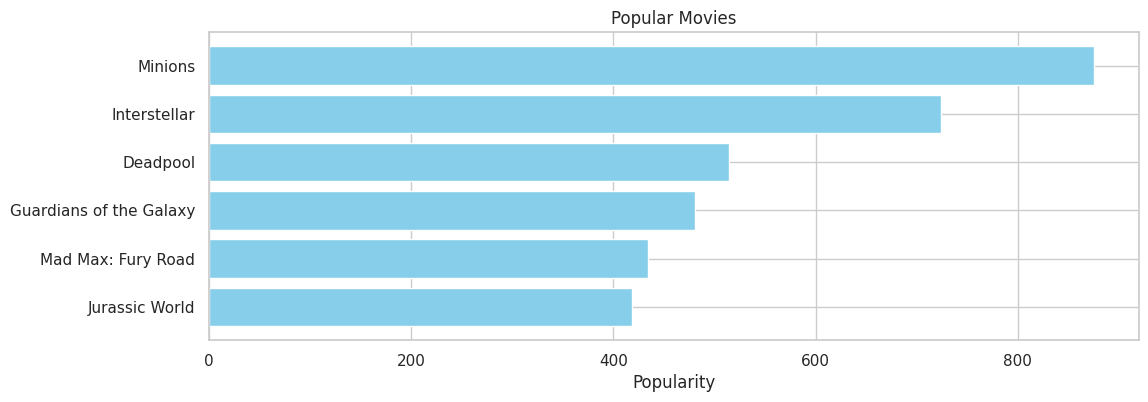

In [84]:
pop= final_movies_df.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

# 5- Content Based Filtering


In [88]:
final_movies_df['overview'].info()


<class 'pandas.core.series.Series'>
Int64Index: 4793 entries, 1881 to 242
Series name: overview
Non-Null Count  Dtype 
--------------  ----- 
4793 non-null   object
dtypes: object(1)
memory usage: 74.9+ KB


We want to convert the text descriptions of movies into numerical vectors. To do this, we use a technique called Term Frequency-Inverse Document Frequency (TF-IDF).

Term Frequency (TF) tells us how often a word appears in a document relative to the total number of words in that document. It's a measure of how important a word is within a single document.

Inverse Document Frequency (IDF) measures the importance of a word across all the documents in our dataset. It's calculated as the logarithm of the total number of documents divided by the number of documents containing that word.

By multiplying TF and IDF, we get a score that represents the importance of a word in a specific document relative to its importance across all documents. We use this score to create a numerical representation of the movie descriptions.

Scikit-learn provides a convenient `TfIdfVectorizer` class that helps us compute these TF-IDF scores easily. This process reduces the impact of frequently occurring words in the movie descriptions, giving more weight to unique and meaningful words when calculating similarity scores.

In [90]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Check for non-string values and replace them with an empty string
final_movies_df['overview'] = final_movies_df['overview'].apply(lambda x: str(x) if isinstance(x, (int, float)) else x)
final_movies_df['overview'] = final_movies_df['overview'].fillna('')

# Define a TF-IDF Vectorizer Object. Remove all English stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(final_movies_df['overview'])

# Output the shape of tfidf_matrix
print(tfidf_matrix.shape)


(4793, 20968)


Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.


similarity = $$ cos(𝜃) = \frac{A.B}{\|A\| \cdot \|B\|} $$


$$  \text{cosine similarity} = \frac {\sum_{i=1}^{n}  A_i . B_i}{\sqrt {\sum \limits _{i=1}^{n}  A_i^2} .\sqrt {\sum_{i =1}^{n} B_i^2 }}$$

In [91]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [92]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(final_movies_df.index, index=final_movies_df['title']).drop_duplicates()

In [94]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return final_movies_df['title'].iloc[movie_indices]

In [95]:
get_recommendations('The Dark Knight Rises')


3526            The Sting
3194       All or Nothing
3466        Sliding Doors
4624            Locker 13
2917          The Fighter
4036            Antibirth
2849             Nebraska
3491         The Wackness
3504                11:14
3346    Jumping the Broom
Name: title, dtype: object

In [96]:
get_recommendations('Fight Club')


396               Enemy of the State
3411                The Chumscrubber
4366    Who Killed the Electric Car?
1163                   Scary Movie 4
4632                Lovely & Amazing
3726                      Sexy Beast
3412                           Shade
3872                           Bella
3038           Hey Arnold! The Movie
2124                Lakeview Terrace
Name: title, dtype: object

## 5-1- features

In [97]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    final_movies_df[feature] = final_movies_df[feature].apply(literal_eval)

In [98]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [99]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [100]:
# Define new director, cast, genres and keywords features that are in a suitable form.
final_movies_df['director'] = final_movies_df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    final_movies_df[feature] = final_movies_df[feature].apply(get_list)

In [101]:
# Print the new features of the first 3 films
final_movies_df[['title', 'cast', 'director', 'keywords', 'genres']].head()

,title,cast,director,keywords,genres
1881,The Shawshank Redemption,"[Tim Robbins, Morgan Freeman, Bob Gunton]",Frank Darabont,"[prison, corruption, police brutality]","[Drama, Crime]"
662,Fight Club,"[Edward Norton, Brad Pitt, Meat Loaf]",David Fincher,"[support group, dual identity, nihilism]",[Drama]
65,The Dark Knight,"[Christian Bale, Heath Ledger, Aaron Eckhart]",Christopher Nolan,"[dc comics, crime fighter, secret identity]","[Drama, Action, Crime]"
3232,Pulp Fiction,"[John Travolta, Samuel L. Jackson, Uma Thurman]",Quentin Tarantino,"[transporter, brothel, drug dealer]","[Thriller, Crime]"
96,Inception,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...",Christopher Nolan,"[loss of lover, dream, kidnapping]","[Action, Thriller, Science Fiction]"


In [102]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [103]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    final_movies_df[feature] = final_movies_df[feature].apply(clean_data)

In [105]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
final_movies_df['soup'] = final_movies_df.apply(create_soup, axis=1)

In [107]:
 #Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(final_movies_df['soup'])

In [108]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [109]:
# Reset index of our main DataFrame and construct reverse mapping as before
final_movies_df = final_movies_df.reset_index()
indices = pd.Series(final_movies_df.index, index=final_movies_df['title'])

In [111]:
get_recommendations('Up', cosine_sim2)


91                                         Monsters, Inc.
2627    Alpha and Omega: The Legend of the Saw Tooth Cave
3605                                     Meet the Deedles
2540                                          Elsa & Fred
1163                            A Charlie Brown Christmas
2797                                      Running Forever
4271                                          The Nut Job
19                                             Inside Out
57                                              Toy Story
92                                            Toy Story 3
Name: title, dtype: object

# 6- Collaborative Filtering


Collaborative Filtering
Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. It is basically of two types:


1.   User based filtering
2.   Item Based Collaborative Filtering



In [7]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811590 sha256=3bccd3bfe05f0716f826e727a36f952b14c75f614cf15f74820b96ed7f80dca6
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [10]:
from surprise import Reader, Dataset, SVD
reader = Reader()
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [12]:
from sklearn.model_selection import cross_val_score

data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)


In [13]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import SVD




# Create an SVD model
svd = SVD()

# Perform cross-validation and evaluate the model
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the average RMSE and MAE scores
print("Average RMSE:", results['test_rmse'].mean())
print("Average MAE:", results['test_mae'].mean())


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8825  0.8674  0.8799  0.8670  0.8698  0.8733  0.0066  
MAE (testset)     0.6772  0.6669  0.6747  0.6677  0.6677  0.6708  0.0043  
Fit time          2.02    1.37    1.34    1.36    1.37    1.49    0.27    
Test time         0.39    0.12    0.17    0.11    0.14    0.19    0.10    
Average RMSE: 0.8733098297622955
Average MAE: 0.6708157351959663


In [14]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [15]:
df[df['userId'] == 1]


,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
227,1,3744,4.0,964980694,0,227
228,1,3793,5.0,964981855,0,228
229,1,3809,4.0,964981220,0,229
230,1,4006,4.0,964982903,0,230


In [16]:
svd.predict(1, 302, 3)


Prediction(uid=1, iid=302, r_ui=3, est=4.287220623283347, details={'was_impossible': False})

# 7- Matrix Factorization
Alternative Least square ALS

 Alternating Least Squares (ALS) is a matrix factorization technique often used in recommendation systems. It's a mathematical method that helps find patterns in user-item interactions to make personalized recommendations. Here's a simplified explanation in an academic theme:

In [18]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=c7c4dc482c6c2349d3636c2e4b04fad4a98603c30ccc93a08cf263e7e61b6923
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [24]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


In [19]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [41]:
# Initialize a Spark session
spark = SparkSession.builder.appName("ALSRecommendation").getOrCreate()

spark_dataframe = spark.createDataFrame(df)



In [42]:
spark_dataframe.show()


+------+-------+------+---------+----+-----+
|userId|movieId|rating|timestamp|user|movie|
+------+-------+------+---------+----+-----+
|     1|      1|   4.0|964982703|   0|    0|
|     1|      3|   4.0|964981247|   0|    1|
|     1|      6|   4.0|964982224|   0|    2|
|     1|     47|   5.0|964983815|   0|    3|
|     1|     50|   5.0|964982931|   0|    4|
|     1|     70|   3.0|964982400|   0|    5|
|     1|    101|   5.0|964980868|   0|    6|
|     1|    110|   4.0|964982176|   0|    7|
|     1|    151|   5.0|964984041|   0|    8|
|     1|    157|   5.0|964984100|   0|    9|
|     1|    163|   5.0|964983650|   0|   10|
|     1|    216|   5.0|964981208|   0|   11|
|     1|    223|   3.0|964980985|   0|   12|
|     1|    231|   5.0|964981179|   0|   13|
|     1|    235|   4.0|964980908|   0|   14|
|     1|    260|   5.0|964981680|   0|   15|
|     1|    296|   3.0|964982967|   0|   16|
|     1|    316|   3.0|964982310|   0|   17|
|     1|    333|   5.0|964981179|   0|   18|
|     1|  

In [77]:
df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [86]:

# Assuming you have a DataFrame called 'df' with columns 'userId', 'movieId', and 'rating'

# Use the pivot function to create the user-item rating matrix
ratings_matrix = df.pivot(index='userId', columns='movieId', values='rating')

# Replace NaN values with zeros (assuming missing ratings should be considered as zero)
ratings_matrix = ratings_matrix.fillna(0)

# Convert the ratings matrix to a NumPy array for further processing (if needed)
ratings = ratings_matrix.to_numpy()

# Compute the sparsity of the matrix
sparsity = 100 * (1.0 - (ratings_matrix.values > 0).sum() / ratings_matrix.size)

print('dimension: ', ratings_matrix.shape)
print('sparsity: {:.1f}%'.format(sparsity))


dimension:  (610, 9724)
sparsity: 98.3%


In [112]:
ratings

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]], dtype=float32)

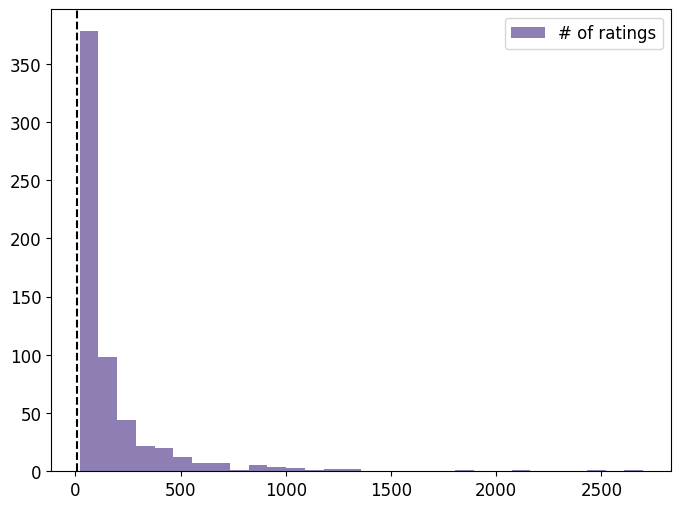

In [114]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.hist(np.sum(ratings != 0, axis = 1), histtype = 'stepfilled', bins = 30,
         alpha = 0.85, label = '# of ratings', color = '#7A68A6')
plt.axvline(x = 10, color = 'black', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

In [109]:
  test = np.zeros(ratings.shape)
  train = ratings.copy()
  for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 10, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]

    # assert that training and testing set are truly disjoint
  assert np.all(train * test == 0)

In [110]:
train

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]], dtype=float32)

In [124]:
from sklearn.metrics import mean_squared_error
from subprocess import call

class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix

    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm

    n_factors : int
        number of latent factors to use in matrix
        factorization model, some machine-learning libraries
        denote this as rank

    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors

    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))

        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors)
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)

        return self

    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs

    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred

    def compute_mse(self, y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [121]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')


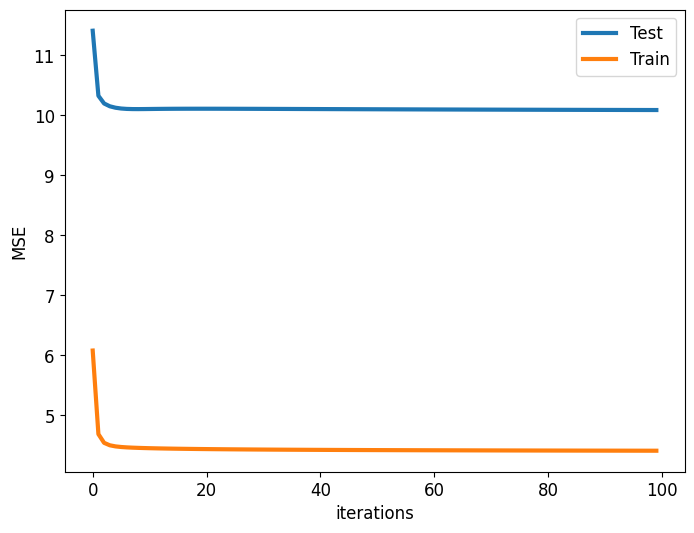

In [125]:
als = ExplicitMF(n_iters = 100, n_factors = 40, reg = 0.01)
als.fit(train,test)
plot_learning_curve(als)